<a href="https://colab.research.google.com/github/vivianlin2000/Computer-Vision-Classification-for-Chest-X-Ray-Imaging/blob/main/CNN_Classification_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io, transform
from keras.utils import to_categorical, load_img, img_to_array
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix
import keras
from keras import backend as K

# LOADING DATA

In [ ]:
# load training data into dataframe
def load_data(path):
    path = Path(path)
    normal = (path/'NORMAL').glob('*.jpeg')
    pneumonia = (path/'PNEUMONIA').glob('*.jpeg')
    data = [[img, 'NORMAL'] for img in normal] + [[img, 'PNEUMONIA'] for img in pneumonia]
    df = pd.DataFrame(data, columns=['img', 'label'])
    return df
    

# DISPLAY DATA

In [ ]:
# display x-ray images
def display_image(data, preprocessed=False):
    indices = np.arange(len(data.index))
    np.random.shuffle(indices)
    
    plt.figure(figsize=(10,5))
    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        img = data['img'][indices[i]]
        if not preprocessed:
            img = io.imread(str(img))
            img = transform.resize(img, (224,224), anti_aliasing=True)
        plt.imshow(img)
        plt.title(data['label'][indices[i]])
        plt.axis("off")
    plt.figure(figsize=(10,5))
    

# PREPROCESSING IMAGES
- resize to all same size
- 3 channel
- RGB format
- normalize to [0, 1]
- convert labels to one-hot encoding

In [ ]:
def preprocess_data(df, as_gray = False):
    # IMAGE SIZE = (224, 224)
    df['img'] = df['img'].apply(lambda x: transform.resize(io.imread(str(x), as_gray=as_gray), (224,224), anti_aliasing=True))
    
    # 3 CHANNELS
    df['img'] = df['img'].apply(lambda x: np.dstack([x, x, x]) if len(x.shape) == 2 else x)
    
    # NORMALIZE VALUES
    # df['img'] = df['img'].apply(lambda x: x.astype(np.float32)/255.0)
    
    # CONVERT LABELS
    # 0: NORMAL    1: PNEUMONIA
    label_dict = {'NORMAL': 0, 'PNEUMONIA': 1}
    df['label'] = df['label'].apply(lambda x: to_categorical(label_dict[x], num_classes=2))
    
    x = np.zeros((len(df.index), 224, 224, 3), dtype=np.float32)
    y = np.zeros((len(df.index), 2), dtype=np.float32)
    
    for i in range(len(df.index)):
        x[i] = df.iloc[i]['img']
        y[i] = df.iloc[i]['label']
    return x, y

# NEURAL NETWORK ALGORITHM

In [ ]:
def get_batches(x, y, size):
    # shuffle order of data
    steps = len(x)//size
    batch_data = np.zeros((size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((size, 2), dtype=np.float32)
    
    indices = np.arange(len(x))
    
    i = 0
    while True:
        np.random.shuffle(indices)
        next_batch = indices[i*size:(i+1)*size]
        for j, idx in enumerate(next_batch):
            batch_data[j] = x[idx]
            batch_labels[j] = y[idx]
        i += 1
        yield batch_data, batch_labels
    
    if i >= steps:
        i=0
        

## ADD CONVOLUTIONS

In [ ]:
def generate_model():
    # Start with 3 convolutions+relu, 3 max pooling, and 2 dense layers 
    model = Sequential()

    # Convolution Layer 1: 32 filters
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
    # ReLu Activation
    # transforms output values between 0 to 1
    model.add(Activation('relu'))
    # Pooling Layer 1
    # downsample input representation (reduce overfitting and computational cost)
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Convolution Layer 2: 32 filters
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    # Pooling Layer 2
    model.add(MaxPooling2D(pool_size=(2,2)))

    # Convolution Layer 3: 64 filters
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    # Pooling Layer 3
    model.add(MaxPooling2D(pool_size=(2,2)))

    # converts 3D feature mapsa to 1D feature vectors
    model.add(Flatten())

    # Dense Layer 1
    model.add(Dense(64))
    model.add(Activation('relu'))
    # Dense Layer 2
    model.add(Dense(2))
    # softmax activation
    model.add(Activation('softmax'))
    return model

In [ ]:
#val_path = "chest_xray/val"
#test_path = "chest_xray/test"
#train_path = "chest_xray/train"
#val_path = "chest_xray/val"
#test_path = "chest_xray/test"
train_data = load_data(train_path)
val_data = load_data(val_path)
test_data = load_data(test_path)

IndexError: ignored

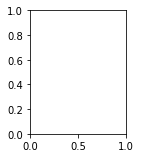

In [ ]:
display_image(train_data)

## USE PRETRAINED NETWORK

In [ ]:
train_x, train_y = preprocess_data(train_data)
val_x, val_y = preprocess_data(val_data)
test_x, test_y = preprocess_data(test_data)

In [ ]:
# number of images fed to the network in a single forward pass
batch_size = 16
# number of times network processes the whole training dataset
epochs = 3
# number of steps in one epoch
training_steps = len(train_data.index)//batch_size
# binary cross-entropy as loss function due to 2 classes, 0 and 1

model = generate_model()
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=1e-5), 
              metrics=['mse', 'accuracy'])

In [ ]:
batch_generator = get_batches(train_x, train_y, batch_size)
history = model.fit(batch_generator, 
                    epochs=epochs, 
                    steps_per_epoch=training_steps,
                    validation_data = (val_x, val_y))

# TRANSFER LEARNING

In [ ]:
def generate_transfer_model():
    model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
    
    layer = Dense(1024, activation='relu')(model.layers[-4].output)
    layer = Dropout(0.7)(layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(2, activation='softmax')(layer)
    model = Model(model.input, layer)
    
    return model

In [ ]:
vgg_model = generate_transfer_model()

In [ ]:
for layer in vgg_model.layers[:-10]:
    layer.trainable = False
vgg_model.compile(loss='binary_crossentropy',
                  optimizer = Adam(learning_rate=1e-4, decay=1e-5),
                  metrics=['accuracy'])

In [ ]:
history = vgg_model.fit(batch_generator, 
                        epochs=epochs,
                        steps_per_epoch=training_steps,
                        validation_data = (val_x, val_y),
                        class_weight={0:1.0, 1:0.4})

In [ ]:
loss, acc = model.evaluate(test_data, test_labels, batch_size=16)
print(f'Manual model - Loss: {loss}\t Acc: {acc}')
loss, acc = vgg_model.evaluate(test_data, test_labels, batch_size=16)
print(f'VGG model - Loss: {loss}\t Acc: {acc}')
